# LightGBM booster classifier - Reduced data version V2

#### Loading data & Preprocessing

In [4]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# load data
all_data_dir = "./training_data"
with open(f'{all_data_dir}/train.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)
    Y = np.load(f, allow_pickle=True)

#### Dimensionality reduction using PCA

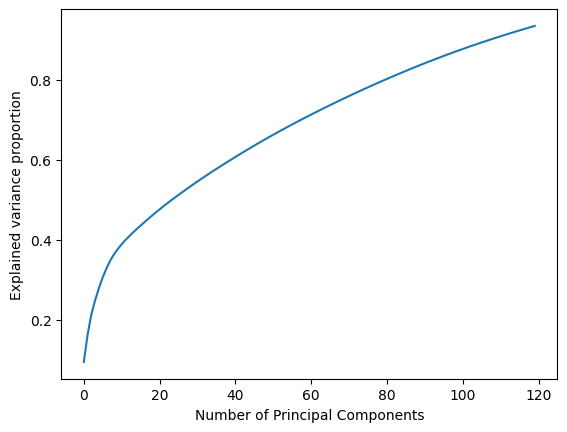

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Applying PCA for dimensionality reduction to 120 components
pca = PCA(n_components=120)
pca_results = pca.fit_transform(scaled_data)

# Analizing results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Graph of cumulative variance ratio
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained variance proportion')
plt.show()

#### Splitting data for training and testing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(normalize(pca_results), Y, test_size=0.3, random_state=42)

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")

Training data: (105, 120), (105,)
Testing data: (45, 120), (45,)


#### Encoding labels

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#### Defining model configurations & training

In [18]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train_encoded)
lgb_test = lgb.Dataset(X_test, y_test_encoded)

params = {
    'task': 'train'
    ,'boosting_type': 'gbdt'
    ,'objective': 'multiclass'
    ,'num_class': 5
    ,'metric': 'multi_logloss'
    }

gbm = lgb.train(params, lgb_train, num_boost_round=150, valid_sets=[lgb_test])
gbm.save_model("models/vowel_clf_v2.txt")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4401
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 120
[LightGBM] [Info] Start training from score -1.820747
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.658228
[LightGBM] [Info] Start training from score -1.395864
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

#### Performance evaluation & Results

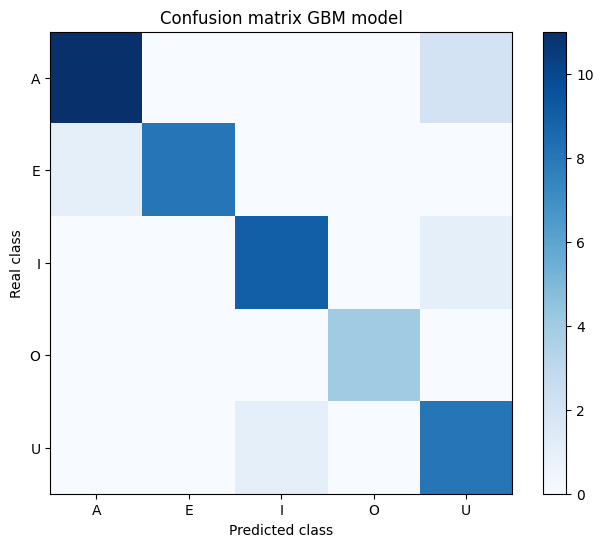

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       1.00      0.89      0.94         9
           2       0.90      0.90      0.90        10
           3       1.00      1.00      1.00         4
           4       0.73      0.89      0.80         9

    accuracy                           0.89        45
   macro avg       0.91      0.90      0.90        45
weighted avg       0.90      0.89      0.89        45



In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# load trained model
model = lgb.Booster(model_file="models/vowel_clf_v2.txt")

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

y_test_encoded = label_encoder.transform(y_test)

vowels = ['A', 'E', 'I', 'O', 'U']
predicted_vowels = [vowels[i] for i in predicted_classes]
true_vowels = [vowels[i] for i in y_test_encoded]

# create confusion matrix
conf_matrix = confusion_matrix(true_vowels, predicted_vowels, labels=vowels)

# confusion matrix visualization
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix GBM model')
plt.colorbar()

plt.xticks(range(len(vowels)), vowels)
plt.yticks(range(len(vowels)), vowels)

plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.show()

# print classification report
print("Classification report:\n", classification_report(y_test_encoded, predicted_classes))